In [203]:
import numpy as np
import pandas as pd
from datetime import datetime
import calendar
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

Based on https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

### Read data

In [2]:
data = {
    'av': pd.read_csv('data/air_visit_data.csv'),
    'as': pd.read_csv('data/air_store_info.csv'),
    'hs': pd.read_csv('data/hpg_store_info.csv'),
    'ar': pd.read_csv('data/air_reserve.csv'),
    'hr': pd.read_csv('data/hpg_reserve.csv'),
    'sr': pd.read_csv('data/store_id_relation.csv'),
    'ss': pd.read_csv('data/sample_submission.csv'),
    'di': pd.read_csv('data/date_info.csv', parse_dates=True).rename(columns={'calendar_date':'visit_date'})
    }

### Prepare date_info

In [3]:
data['di']['visit_date'] = pd.to_datetime(data['di']['visit_date'])
#data['di'].set_index(['visit_date'], inplace=True)
#data['di'].index.name = None
data['di'].day_of_week = data['di'].day_of_week.apply(list(calendar.day_name).index)
data['di'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,4,1
1,2016-01-02,5,1
2,2016-01-03,6,1
3,2016-01-04,0,0
4,2016-01-05,1,0


### Prepare air_visit_data

In [4]:
data['av']['visit_date'] = pd.to_datetime(data['av']['visit_date'])
data['av'] = pd.merge(data['av'], data['di'], how='left', on=['visit_date'])
data['av']['visitors'] = data['av']['visitors'].astype('float64')
data['av'].head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25.0,2,0
1,air_ba937bf13d40fb24,2016-01-14,32.0,3,0
2,air_ba937bf13d40fb24,2016-01-15,29.0,4,0
3,air_ba937bf13d40fb24,2016-01-16,22.0,5,0
4,air_ba937bf13d40fb24,2016-01-18,6.0,0,0


In [5]:
data['av']['day_of_week'] = data['av'].apply(lambda row: 7 if row['holiday_flg'] == 1 else row['day_of_week'], axis=1)
data['av'].drop(['holiday_flg'], axis=1, inplace=True)
data['av'].head()

,air_store_id,visit_date,visitors,day_of_week
0,air_ba937bf13d40fb24,2016-01-13,25.0,2
1,air_ba937bf13d40fb24,2016-01-14,32.0,3
2,air_ba937bf13d40fb24,2016-01-15,29.0,4
3,air_ba937bf13d40fb24,2016-01-16,22.0,5
4,air_ba937bf13d40fb24,2016-01-18,6.0,0


### Prepare submission data

In [6]:
data['ss']['store_id'] = data['ss'].apply(lambda row: row.loc['id'][:row.loc['id'].rindex('_')], axis=1)
data['ss']['visit_date'] = data['ss'].apply(lambda row: row.loc['id'][row.loc['id'].rindex('_')+1:], axis=1)
data['ss']['visit_date'] = pd.to_datetime(data['ss']['visit_date'])
data['ss'].head()

,id,visitors,store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27


In [7]:
data['ss'] = pd.merge(data['ss'], data['di'], how='left', on=['visit_date'])
data['ss'].head()

,id,visitors,store_id,visit_date,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,6,0
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,0,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,1,0
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2,0
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,3,0


In [260]:
data['ss']['day_of_week'] = data['ss'].apply(lambda row: 7 if row['holiday_flg'] == 1 else row['day_of_week'], axis=1)
data['ss'].drop(['holiday_flg'], axis=1, inplace=True)
data['ss']

KeyError: ('holiday_flg', u'occurred at index 0')

In [265]:
len(data['ss']['store_id'].unique())

821

### Analyzing TS for one restaurant

In [82]:
ts = data['av'].groupby(['air_store_id']).get_group('air_ba937bf13d40fb24')[['visit_date', 'visitors']]
ts.set_index(['visit_date'], inplace=True)
ts.index.name = None
ts.head()

,visitors
2016-01-13,25.0
2016-01-14,32.0
2016-01-15,29.0
2016-01-16,22.0
2016-01-18,6.0


In [84]:
print ts.loc['2016-01-16']
print ts.loc['2016-01-18']
print ts.loc['2016-01-17']

visitors    22.0
Name: 2016-01-16 00:00:00, dtype: float64
visitors    6.0
Name: 2016-01-18 00:00:00, dtype: float64


KeyError: 'the label [2016-01-17] is not in the [index]'

In [85]:
ts = ts.resample('D').mean().interpolate()

In [86]:
print ts.loc['2016-01-16']
print ts.loc['2016-01-18']
print ts.loc['2016-01-17']

visitors    22.0
Name: 2016-01-16 00:00:00, dtype: float64
visitors    6.0
Name: 2016-01-18 00:00:00, dtype: float64
visitors    14.0
Name: 2016-01-17 00:00:00, dtype: float64


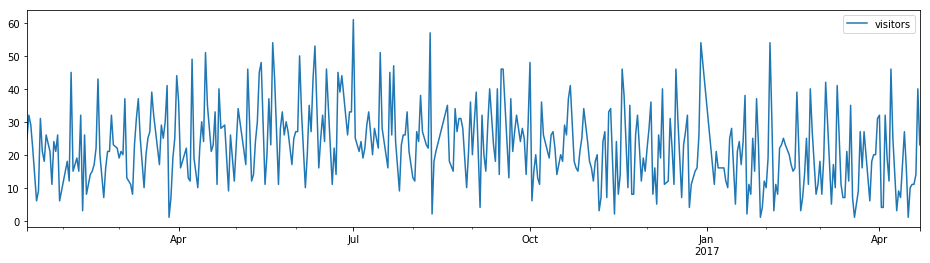

In [127]:
ts.plot( figsize=(16,4))

/home/astar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


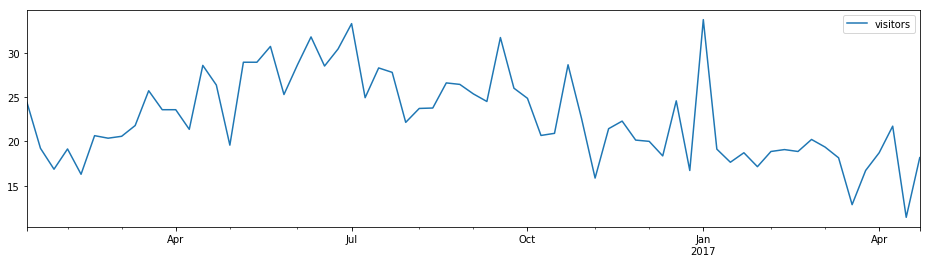

In [128]:
ts_week = ts.resample('W', how='mean')
ts_week.plot(figsize=(16,4))

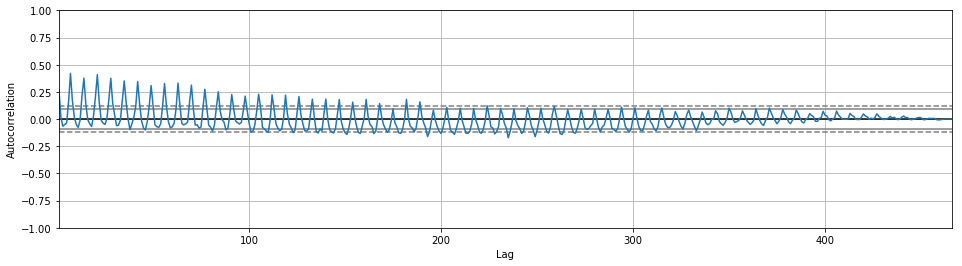

In [143]:
plt.rcParams["figure.figsize"] = (16,4)
autocorrelation_plot(ts)

In [153]:
def test_stationarity(timeseries):
    plt.plot(timeseries, color='blue',label='Original')
    rolling_mean = timeseries.rolling(window=7,center=False).mean()
    rolling_std = timeseries.rolling(window=7,center=False).std()
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    test = adfuller(timeseries.iloc[:,0].values)
    print 'Results of Dickey-Fuller Test:'
    print 'adf: ', test[0]
    print 'p-value: ', test[1]
    print 'Critical values: ', test[4]

Results of Dickey-Fuller Test:
adf:  -2.64208841766
p-value:  0.0846066449731
Critical values:  {'5%': -2.8679556266351653, '1%': -3.4449004999252368, '10%': -2.5701872889419688}


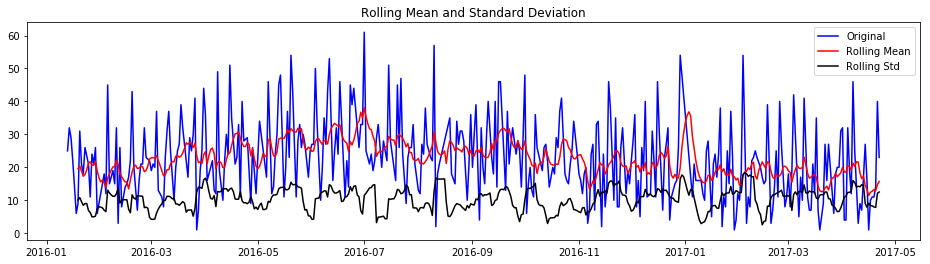

In [154]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
adf:  -12.0906658954
p-value:  2.12632692771e-22
Critical values:  {'5%': -2.8679556266351653, '1%': -3.4449004999252368, '10%': -2.5701872889419688}


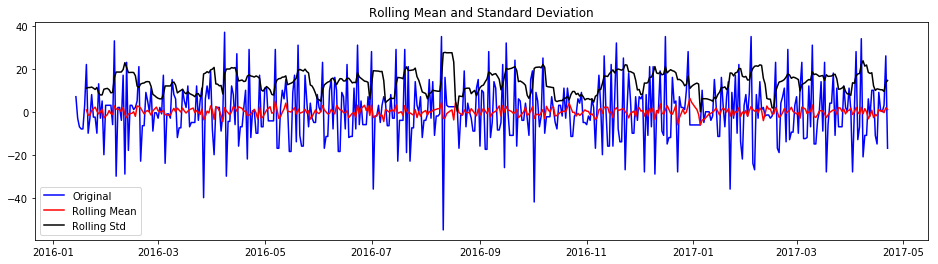

In [156]:
ts1diff = ts.diff(periods=1).dropna()
test_stationarity(ts1diff)

So we have d == 1

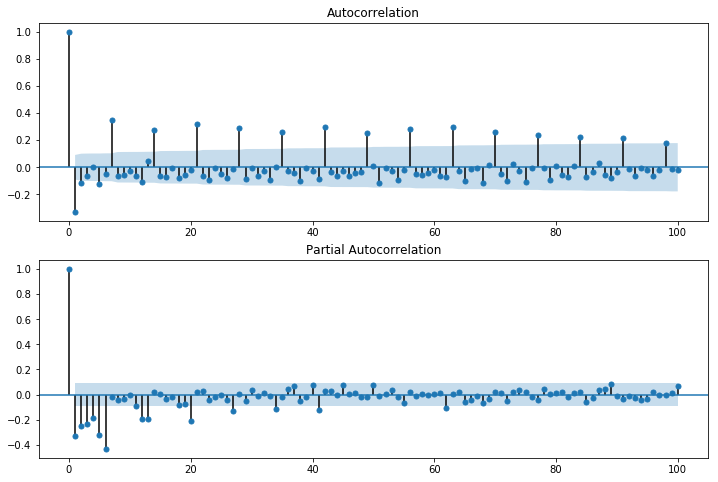

In [170]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts1diff.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts1diff, lags=100, ax=ax2)

So we have q from ACF and q == 1 or 5 or 8 and p from PACF and p == 0 or 6

In [266]:
model1 = ARIMA(ts[:'2017-04-01'], order=(6,1,1), freq='D').fit()
print model1.summary()

                             ARIMA Model Results                              
Dep. Variable:             D.visitors   No. Observations:                  444
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1656.470
Method:                       css-mle   S.D. of innovations             10.067
Date:                Thu, 04 Jan 2018   AIC                           3330.941
Time:                        22:23:39   BIC                           3367.803
Sample:                    01-14-2016   HQIC                          3345.478
                         - 04-01-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013      0.101      0.013      0.990      -0.197       0.199
ar.L1.D.visitors    -0.6470      0.111     -5.815      0.000      -0.865      -0.429
ar.L2.D.visitors    -0.6217 

In [267]:
model2 = ARIMA(ts[:'2017-04-01'], order=(6,1,3), freq='D').fit()
print model2.summary()

/home/astar/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.visitors   No. Observations:                  444
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -1643.243
Method:                       css-mle   S.D. of innovations              9.738
Date:                Thu, 04 Jan 2018   AIC                           3308.485
Time:                        22:23:41   BIC                           3353.539
Sample:                    01-14-2016   HQIC                          3326.253
                         - 04-01-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0045      0.023     -0.198      0.843      -0.049       0.040
ar.L1.D.visitors    -0.2682      0.051     -5.218      0.000      -0.369      -0.167
ar.L2.D.visitors    -0.9419 

In [268]:
model3 = ARIMA(ts[:'2017-04-01'], order=(6,1,5), freq='D').fit()
print model3.summary()

/home/astar/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.visitors   No. Observations:                  444
Model:                 ARIMA(6, 1, 5)   Log Likelihood               -1628.094
Method:                       css-mle   S.D. of innovations              9.312
Date:                Thu, 04 Jan 2018   AIC                           3282.187
Time:                        22:23:46   BIC                           3335.433
Sample:                    01-14-2016   HQIC                          3303.185
                         - 04-01-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0017      0.020     -0.083      0.934      -0.041       0.038
ar.L1.D.visitors    -0.3690      0.020    -18.249      0.000      -0.409      -0.329
ar.L2.D.visitors     0.2748 

In [269]:
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
q_test1 = acf(model1.resid, qstat=True)
q_test2 = acf(model2.resid, qstat=True)
q_test3 = acf(model3.resid, qstat=True)
print pd.DataFrame({'Q-stat-1':q_test1[1], 'p-value-1':q_test1[2], 
                    'Q-stat-2':q_test2[1], 'p-value-2':q_test2[2], 
                    'Q-stat-3':q_test3[1], 'p-value-3':q_test3[2],})

     Q-stat-1   Q-stat-2   Q-stat-3  p-value-1     p-value-2  p-value-3
0    0.002138   0.007289   0.000498   0.963121  9.319635e-01   0.982200
1    0.156516   0.034590   0.004615   0.924726  9.828535e-01   0.997695
2    0.518846   0.442901   0.043665   0.914732  9.312444e-01   0.997605
3    0.748947   2.111167   0.487345   0.945158  7.153211e-01   0.974721
4    2.305952   2.435231  14.515288   0.805392  7.862163e-01   0.012647
5    8.954520   5.061792  16.859121   0.176152  5.359126e-01   0.009815
6   17.218259  13.038234  24.819840   0.016042  7.118229e-02   0.000817
7   20.324410  13.504632  24.822721   0.009176  9.562624e-02   0.001666
8   20.365983  13.566645  25.514462   0.015783  1.385970e-01   0.002452
9   20.380947  19.033978  27.124842   0.025849  3.983322e-02   0.002488
10  20.905437  26.301795  27.386388   0.034364  5.850990e-03   0.004016
11  21.613907  26.360356  35.901898   0.042082  9.541309e-03   0.000336
12  22.774388  27.687194  36.496983   0.044465  1.000337e-02   0

In [270]:
y_pred1 = model1.predict('2017-04-02','2017-04-22', typ='levels', dynamic=True)
y_pred2 = model2.predict('2017-04-02','2017-04-22', typ='levels', dynamic=True)
y_pred3 = model3.predict('2017-04-02','2017-04-22', typ='levels', dynamic=True)
y_true = ts['2017-04-02':'2017-04-22']
r2_1 = r2_score(y_true, y_pred1)
r2_2 = r2_score(y_true, y_pred2)
r2_3 = r2_score(y_true, y_pred3)
print 'R^2_1: %1.2f' % r2_1
print 'R^2_2: %1.2f' % r2_2
print 'R^2_3: %1.2f' % r2_3

R^2_1: 0.06
R^2_2: 0.21
R^2_3: 0.34


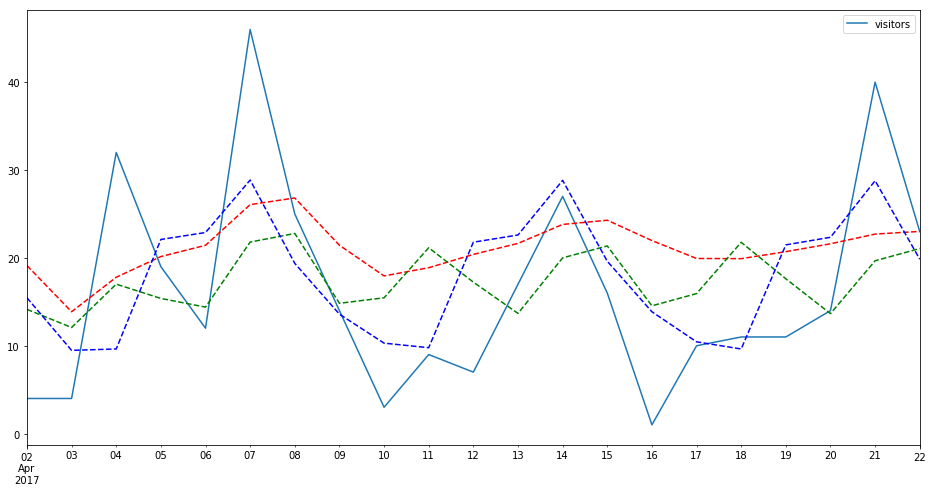

In [271]:
ts['2017-04-02':].plot(figsize=(16,8))
y_pred1.plot(style='r--', label='model1')
y_pred2.plot(style='g--', label='model2')
y_pred3.plot(style='b--')

In [328]:
model = ARIMA(ts[:], order=(13,1,4), freq='D').fit()
print model.summary()

/home/astar/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.visitors   No. Observations:                  465
Model:                ARIMA(13, 1, 4)   Log Likelihood               -1702.081
Method:                       css-mle   S.D. of innovations              9.303
Date:                Thu, 04 Jan 2018   AIC                           3442.161
Time:                        22:38:32   BIC                           3520.860
Sample:                    01-14-2016   HQIC                          3473.137
                         - 04-22-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0063      0.021     -0.299      0.765      -0.047       0.035
ar.L1.D.visitors      0.2707        nan        nan        nan         nan         nan
ar.L2.D.visitors     -0.

In [329]:
y_pred = model.predict('2017-04-23','2017-05-31', typ='levels', dynamic=True)

In [330]:
y_pred

2017-04-23    10.634458
2017-04-24    12.869390
2017-04-25    17.560244
2017-04-26    13.697364
2017-04-27    15.002446
2017-04-28    27.946739
2017-04-29    21.425359
2017-04-30    11.351855
2017-05-01    12.347871
2017-05-02    16.950996
2017-05-03    12.422417
2017-05-04    14.259062
2017-05-05    23.750114
2017-05-06    20.014513
2017-05-07    11.862988
2017-05-08    14.648874
2017-05-09    18.547923
2017-05-10    13.076988
2017-05-11    14.262704
2017-05-12    22.614207
2017-05-13    19.677577
2017-05-14    12.152024
2017-05-15    15.724684
2017-05-16    19.438607
2017-05-17    13.445404
2017-05-18    13.666912
2017-05-19    21.469122
2017-05-20    19.124892
2017-05-21    12.111079
2017-05-22    15.978203
2017-05-23    19.804450
2017-05-24    13.769090
2017-05-25    13.318436
2017-05-26    20.720909
2017-05-27    18.826676
2017-05-28    12.231022
2017-05-29    16.130917
2017-05-30    20.057208
2017-05-31    14.110932
Freq: D, dtype: float64

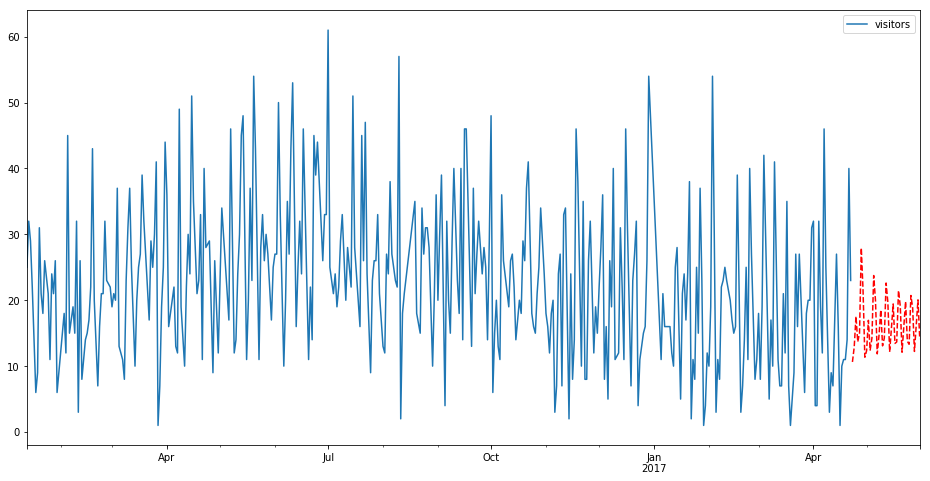

In [331]:
ts[:].plot(figsize=(16,8))
y_pred.plot(style='r--')

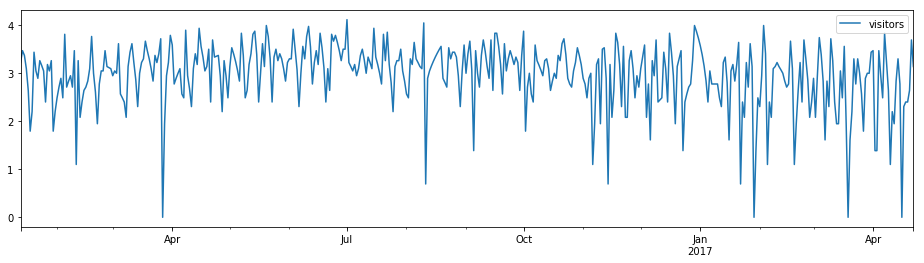

In [109]:
ts_log = np.log(ts)
ts_log.plot( figsize=(16,4))

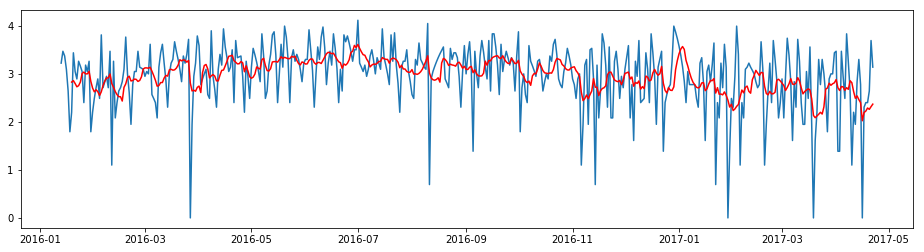

In [110]:
moving_avg = ts_log.rolling(window=7,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [111]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(7)

,visitors
2016-01-13,NaN
2016-01-14,NaN
2016-01-15,NaN
2016-01-16,NaN
2016-01-17,NaN
2016-01-18,NaN
2016-01-19,-0.627203


Results of Dickey-Fuller Test:
Test Statistic                -8.166104e+00
p-value                        8.874744e-13
#Lags Used                     1.500000e+01
Number of Observations Used    4.440000e+02
Critical Value (5%)           -2.868072e+00
Critical Value (1%)           -3.445164e+00
Critical Value (10%)          -2.570249e+00
dtype: float64


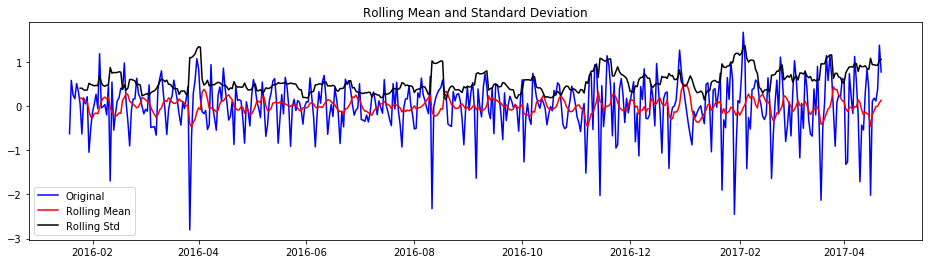

In [112]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

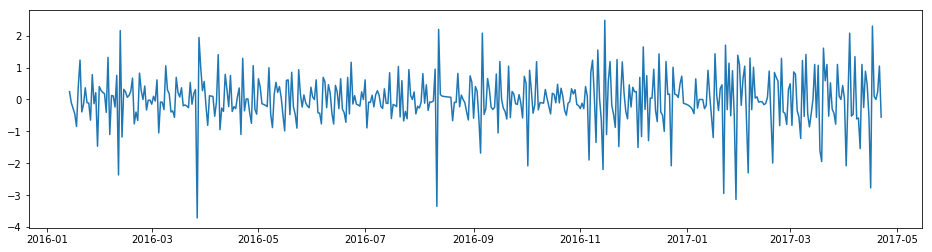

In [113]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.187122e+01
p-value                        6.496722e-22
#Lags Used                     1.200000e+01
Number of Observations Used    4.520000e+02
Critical Value (5%)           -2.867956e+00
Critical Value (1%)           -3.444900e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


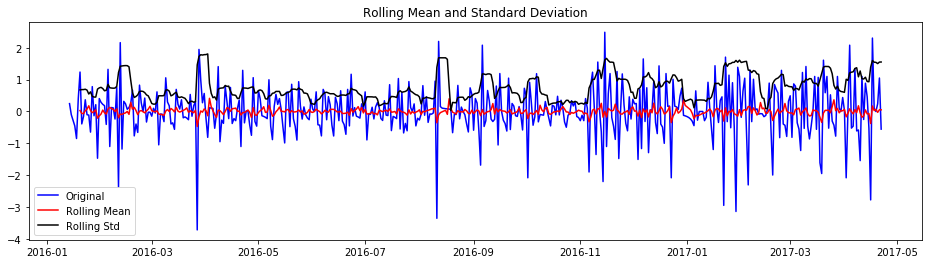

In [114]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [115]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

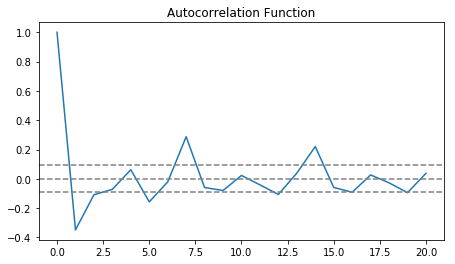

In [116]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

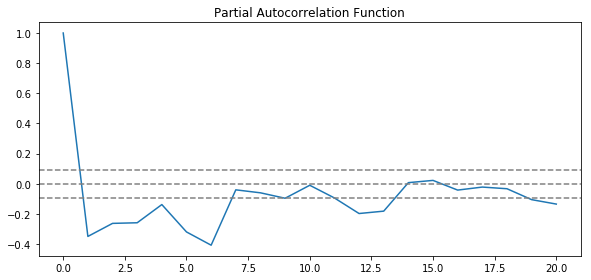

In [117]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

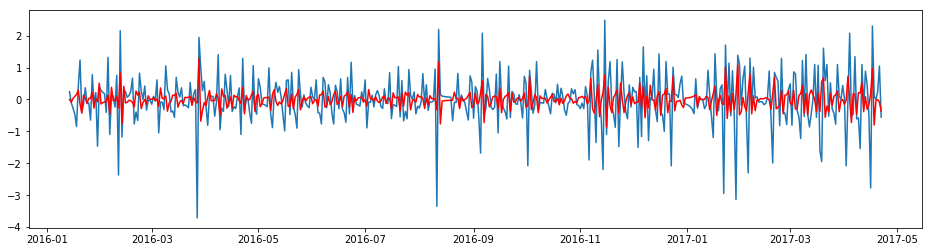

In [119]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

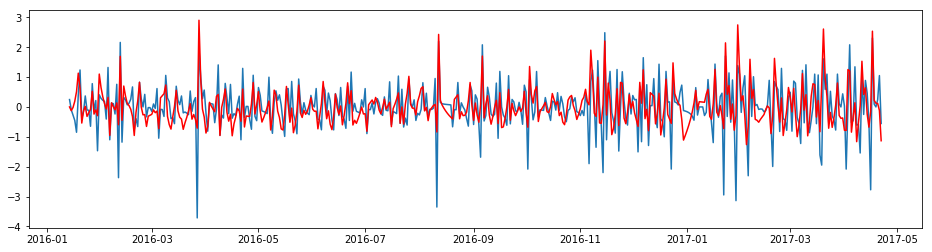

In [120]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

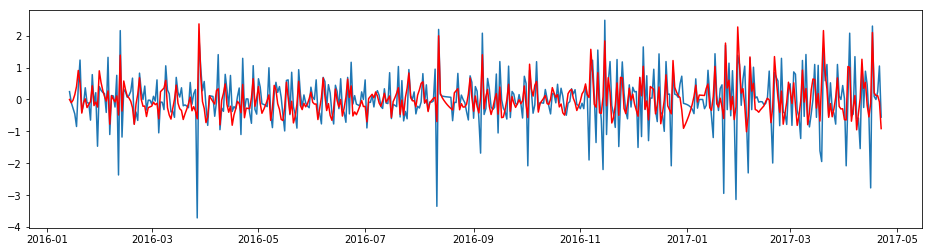

In [121]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [122]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

2016-01-14   -0.000737
2016-01-15   -0.102767
2016-01-16   -0.020927
2016-01-17    0.148400
2016-01-18    0.409284
Freq: D, dtype: float64


In [123]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

2016-01-14   -0.000737
2016-01-15   -0.103504
2016-01-16   -0.124431
2016-01-17    0.023969
2016-01-18    0.433252
Freq: D, dtype: float64


In [124]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2016-01-13         NaN
2016-01-14   -0.000737
2016-01-15   -0.103504
2016-01-16   -0.124431
2016-01-17    0.023969
Freq: D, dtype: float64

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

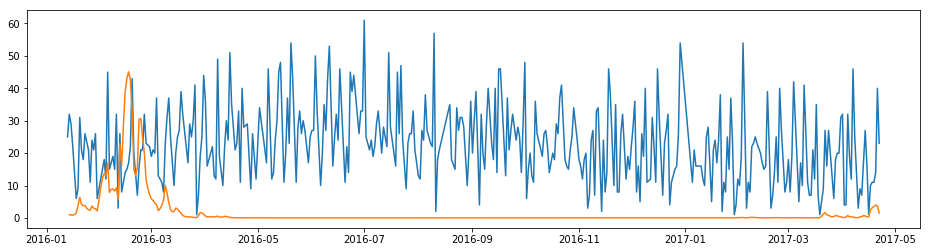

In [125]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

                             ARIMA Model Results                              
Dep. Variable:             D.visitors   No. Observations:                  465
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1761.699
Method:                       css-mle   S.D. of innovations             10.665
Date:                Thu, 04 Jan 2018   AIC                           3531.398
Time:                        20:54:13   BIC                           3547.966
Sample:                    01-14-2016   HQIC                          3537.919
                         - 04-22-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0074      0.019     -0.397      0.691      -0.044       0.029
ar.L1.D.visitors     0.1983      0.047      4.247      0.000       0.107       0.290
ma.L1.D.visitors    -0.9721 

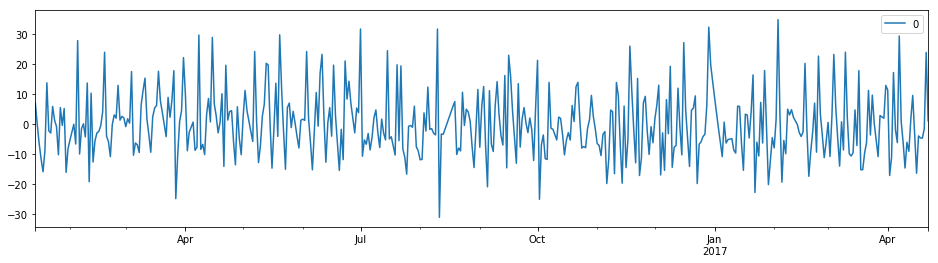

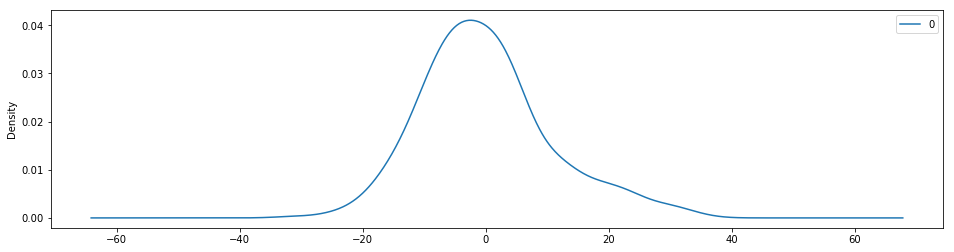

                0
count  465.000000
mean    -0.015035
std     10.693729
min    -31.149727
25%     -7.101999
50%     -1.275242
75%      5.333299
max     34.801840


In [126]:
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit(disp=-1)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())